# LOG6308 : Tp1 - Recommendation by collaboratif filtering 

- Clément Bernard (2096223)
- Ghaith Dekhili ()

## Importations 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from scipy.spatial import distance

## Data 

In [2]:
# The path where is the fold data
PATH_DATA = 'data'

In [3]:
# The items 
items = pd.read_csv(os.path.join(PATH_DATA, 'items.csv'), sep='|')
# User data 
u = pd.read_csv(os.path.join(PATH_DATA, 'u.csv'), sep='|')
# Votes of the user 
votes = pd.read_csv(os.path.join(PATH_DATA, 'votes.csv'), sep='|')

In [4]:
items

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
u

,id,age,gender,job,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [6]:
votes

,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


## Creation of sparse matrix : User-item matrix

In [7]:
# The number of users 
N_USERS = u.shape[0]
# The number of items 
N_ITEMS = items.shape[0]

In [8]:
def create_sparse_matrix(votes) : 
    ''' Create a User-Items sparse matrix '''
    # Create NaN for each items and users 
    data = {i : [np.nan for j in range(N_USERS + 1)] for i in range(N_ITEMS+1)}
    def to_convert(x, data) :
        data[x['item.id']][x['user.id']] = x['rating']
        return None 
    votes.apply(to_convert , axis = 1 , args = [data])
    return pd.DataFrame(data)

In [9]:
user_item = create_sparse_matrix(votes)

In [10]:
user_item

,0,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question 1 

- Tout d'abord, nous creons les indexes qui vont permettre de diviser nos données pour la cross-validation

In [11]:
def kfold(n_data, k = 10 , SEED = 77, shuffle = False ) : 
    ''' Split the data into K-Folds 
        Input : The length of the data to split 
        Output : The indexes of the different folds 
    '''
    # Fix the SEED to have consistent results 
    np.random.seed(SEED)
    # Create the indexes 
    indexes = np.arange(n_data)
    # Shuffle the matrix 
    if shuffle : 
        np.random.shuffle(indexes)
    # The size of the subindexes
    sub_size = n_data // k 
    # Size of the last fold used for the test 
    last_size = sub_size + n_data%k
    # Where we store all the indexes 
    all_indexes = {'train' : [], 'test' : []}
    # Index of the test 
    test_i = 0 
    for i in range(k) :
        train = []
        # Check if we are the last set 
        if test_i == k-1 : 
            all_indexes['test'].append(indexes[-last_size:])
            all_indexes['train'].append(indexes[:-last_size ])
        else : 
            all_indexes['test'].append(indexes[ test_i * sub_size : (test_i+1) * sub_size ])
            # Get the indexes outside the test indexes
            train = [] 
            train.extend(indexes[:test_i * sub_size])
            train.extend(indexes[(test_i+1) * sub_size : ])
            all_indexes['train'].append(train)
        
        
        test_i +=1 
        
    return all_indexes


- Maintenant, nous implémentons les fonctions pour calculer les valeurs moyennes des utilisateurs et items 

In [12]:
def average_user(user_item) : 
    ''' Compute the average score for the users '''
    # Compute the mean for the users 
    return user_item.apply( lambda x : np.mean(x) , axis = 1 ).iloc[1:]
    
def average_item(user_item) : 
    ''' Compute the average score for the items '''
    # Compute the mean for the items 
    return user_item.apply( lambda x : np.mean(x) , axis = 0 ).iloc[1:]

In [13]:
# The mean by users 
user_item_mean_u = average_user(user_item)
# The mean by items
user_item_mean_i = average_item(user_item)

- Valeur moyenne par utilisateur 

In [14]:
user_item_mean_u

1      3.610294
2      3.709677
3      2.796296
4      4.333333
5      2.874286
         ...   
939    4.265306
940    3.457944
941    4.045455
942    4.265823
943    3.410714
Length: 943, dtype: float64

- Valeur moyenne par item

In [15]:
user_item_mean_i

1       3.878319
2       3.206107
3       3.033333
4       3.550239
5       3.302326
          ...   
1678    1.000000
1679    3.000000
1680    2.000000
1681    3.000000
1682    3.000000
Length: 1682, dtype: float64

- Utilisation de la cross-validation pour calculer l'erreur 

In [16]:
user_item

,0,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
votes

,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [18]:
def cross_validation(N ,k , votes = votes , user_item = user_item) : 
    ''' Compute the quadratic error with K-cross-validation
        Inputs : 
            - N : The size of the data to split (either size of items or users)
    '''
    # Dictionnary that will store the errors 
    errors = {}
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = True ).values())) : 
        # Copy the original user-item matrix 
        u_item = user_item.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:2]
        
        def to_convert(x, user_item) :
            # Make the test rating to NaN
            user_item[x['item.id']][x['user.id']] = np.nan
        # Convert the test rating to NaN
        indexes_test.apply(to_convert , axis = 1 , args = [u_item])
        # Get the mean within the training indexes
        mean_item = average_item(u_item)
        mean_user = average_user(u_item)
        # Set the error to 0
        errors[i] = 0 
        
        def compute_dist(x, mean_item, mean_user, user_item, errors, i) :
            '''Compute the RMSE''' 
            # Get the item id 
            item = x['item.id']
            # Get the user id 
            user = x['user.id']
            # Make the prediction : the mean between user and item score 
            prediction = (mean_item[item] + mean_user[user])/2
            # Get the true label 
            true_value = user_item.iloc[user,item]
            # Compute the error 
            error = np.sqrt( ( prediction - true_value)**2)
            # If NaN : pass
            if np.isnan(error) : 
                return None
            # Increment the error 
            errors[i]+=error
            return None 
        # Apply the computation of RMSE 
        indexes_test.apply(compute_dist, axis = 1 , args = [mean_item, mean_user, user_item, errors,i])
        # Normalise by the size of the testing set 
        errors[i]/=indexes_test.shape[0]
            
    return errors
    

In [19]:
error_user = cross_validation( N = votes.shape[0] ,k = 10  )

In [20]:
error_user

{0: 0.7904852542732592,
 1: 0.7970947546098525,
 2: 0.7877259002558626,
 3: 0.7981952841676403,
 4: 0.7868886105352605,
 5: 0.7959348206748117,
 6: 0.7957315357115603,
 7: 0.7945162507362926,
 8: 0.793590239319258,
 9: 0.7891019394296054}

<BarContainer object of 10 artists>

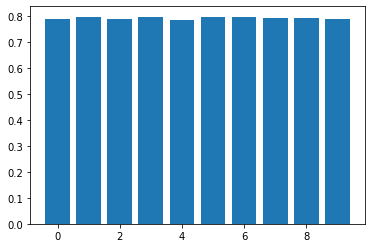

In [21]:
plt.bar(list(error_user.keys()) , list(error_user.values()))

- Print the results 

In [22]:
print('Mean square error for all the K-folds : {}'.format(error_user))
print('Mean square error for all the folds : {}'.format(np.mean(list(error_user.values()))))

Mean square error for all the K-folds : {0: 0.7904852542732592, 1: 0.7970947546098525, 2: 0.7877259002558626, 3: 0.7981952841676403, 4: 0.7868886105352605, 5: 0.7959348206748117, 6: 0.7957315357115603, 7: 0.7945162507362926, 8: 0.793590239319258, 9: 0.7891019394296054}
Mean square error for all the folds : 0.7929264589713403


## Question 2 

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
import time

## 2.a

In [110]:
item_item = user_item.T.copy()

In [111]:
item_item

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
item_item = item_item.iloc[1:,1:]

In [25]:
def similarity(item_item, a, i ) : 
    ''' Compute the similarity between 2 users a and i '''
    u = item_item.iloc[a,:].values.reshape(-1,1)
    v = item_item.iloc[i,:].values.reshape(-1,1)
    u = np.nan_to_num(u,0)
    v = np.nan_to_num(v,0)
    
    return distance.cosine(u,v)

In [119]:
def get_similarity_matrix(item_item) : 
    ''' Return a matrix of size : N_ITEM x N_ITEM with the similarity for each user 
            within the other items '''
    sim_mat = np.zeros((N_ITEMS+1,N_ITEMS+1))
    for a in range(N_ITEMS) :
        """
        indexes_sim = ~item_item.iloc[a,:].isnull()
        user_sim = item_item.loc[:,indexes_sim]
        values_null = user_sim.isnull().sum(axis=1) == user_sim.shape[1]
        user_sim_indexes = np.arange(item_item.shape[0])[~values_null.values]
        """
        for u,user in enumerate(item_item.iloc[a,:].values):
            #return indices of not null values
            myList = item_item.index[item_item.iloc[:,u] > 0].tolist()
            if myList:
                for i in myList:
                    cosine = similarity(item_item, a, i)
                    sim_mat[a,i] = cosine
                break
                
    return sim_mat

In [122]:
initial_time = time.time()
sim_mat = get_similarity_matrix(item_item)
print(time.time()-initial_time)

/home/ghaith/anaconda33/envs/log6308/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


233.83390951156616


In [121]:
sim_mat

array([[0.        ,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.59761782, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.59761782, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.95281693, 0.92170064, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Question 3

## Question 4 

## Question 5 